In [0]:
!pip uninstall arviz
!pip uninstall pymc3
!pip install arviz --no-dependencies
!pip install pymc3

# Change point detection: Introduction

1. http://www.claudiobellei.com/2016/11/15/changepoint-frequentist/
2. http://www.claudiobellei.com/2017/01/25/changepoint-bayesian/

Two types of approaches:
1. Frequentist
2. bayesian

The general framework is always the same: *the underlying probability distribution function of the time series is assumed to change at one (or more) moments in time.*

![alt text](https://imghostr.com/image.php?sig=ZGG4SnmDX&h=d77b3559a76a3b4d67ab6cdbd9f84008&t=1584011371)

#Coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). 

The number of disasters is thought to have been affected by changes in safety regulations during this period. Unfortunately, we also have pair of years with missing data, identified as missing by a nan in the pandas Series. These missing values will be automatically imputed by PyMC3.

We will build a model for this series and attempt to estimate when the change occurred. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables.

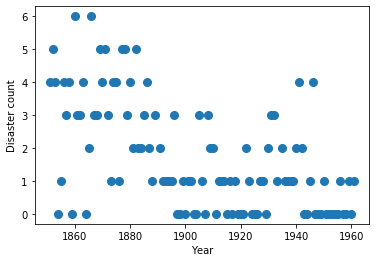

In [12]:
"""
A model for the disasters data with a changepoint
changepoint ~ U(1851, 1962)
early_mean ~ Exp(1.)
late_mean ~ Exp(1.)
disasters[t] ~ Poi(early_mean if t <= switchpoint, late_mean otherwise)

Ref: https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters
     https://github.com/pymc-devs/pymc3/blob/master/pymc3/examples/disaster_model.py
"""

import pandas as pd
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

the parameters are defined as follows: 
* Dt: The number of disasters in year t 
* rt: The rate parameter of the Poisson distribution of disasters in year t. 
* s: The year in which the rate parameter changes (the switchpoint). 
* e: The rate parameter before the switchpoint s. 
* l: The rate parameter after the switchpoint s. 
* tl, th: The lower and upper boundaries of year t.



In [13]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1430: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


#Switch function
A Theano function that works like an if statement. It uses the first argument to switch between the next two arguments.

http://deeplearning.net/software/theano/tutorial/conditions.html

# Sampling

In [16]:
with disaster_model:
    trace = pm.sample(10000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling chain 1, 0 divergences: 100%|██████████| 10500/10500 [00:10<00:00, 966.58it/s]
The number of effective samples is smaller than 10% for some parameters.


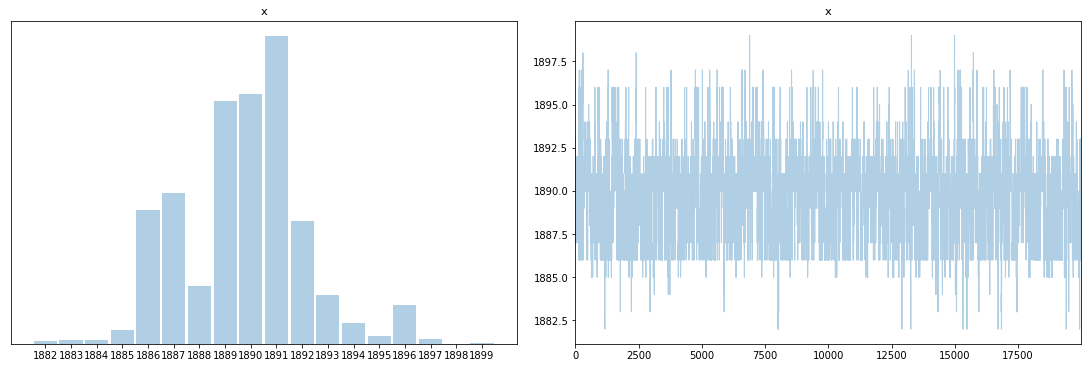

In [26]:
pm.traceplot(trace[switchpoint], figsize= (15, 5));

In the trace plot below we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass.

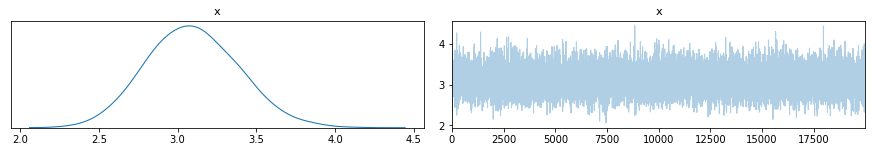

In [21]:
pm.traceplot(trace[early_rate]);

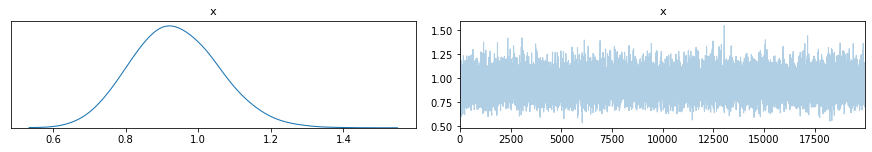

In [22]:
pm.traceplot(trace[late_rate]);

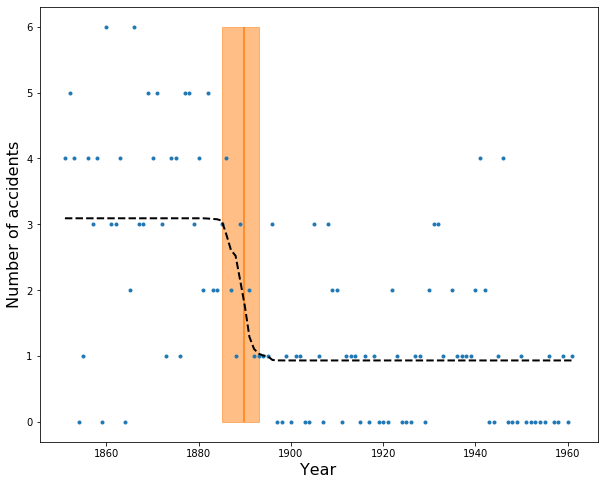

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

# References
1. http://www.claudiobellei.com/2017/01/25/changepoint-bayesian/
2. https://github.com/usnistgov/pmml_pymcBN/blob/master/NX_pymc3_BayesNets.ipynb
3. https://stats.stackexchange.com/questions/234385/how-to-build-a-pymc-model-to-detect-multiple-switch-points
4. 